# Python notebook to plot apical region response to stimulation.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
To verify results incrementally, execute the code one block at a time using &lt;shift-return&gt;.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import numpy as np
import csv
import datetime
from skimage import io
from skimage import exposure
from skimage.util import img_as_float32
from skimage.morphology import binary_erosion
from skimage.morphology import binary_dilation
from skimage.morphology import label
from skimage.morphology import remove_small_objects

#### User editable parameters.
Take care with formatting!\
NOTE: The time-stamped results directory is created in this code block.

In [2]:
# editable user parameters

# stimulation frequency, file name
image_files = {
  1: "../image_stacks/Mistgcamp-3.tif",
  2: "../image_stacks/Mistgcamp-3_0001.tif",
  5: "../image_stacks/Mistgcamp-3_0002.tif",
  10: "../image_stacks/Mistgcamp-3_0003.tif"
}

roi_freq = 5             # simulation frequency to use for generating roi's
roi_quantile = 0.98      # roi threashold 

small_object = 16        # small object size to cull
dilations = 2            # number of dilations to apply

image_bits = 10          # bits per pixel (can be found in the oir meta data)
sample_period = 0.1      # image data sample time period in seconds
stim_start = 100         # stimulation start frame
stim_done = 250          # stimulation end frame (including decay)

# create timestamp based results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = "../results/" + str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
os.mkdir(resultsdir)


#### Get the image stack.


In [3]:
# get the image stack for roi's
A0 = io.imread(image_files[roi_freq])
A0 = np.float32(A0/(2.0**image_bits))

# average out y-direction aliasing over every other line
for n in range(A0.shape[0] - 1): # moving average over every two lines
  A0[n] = (A0[n] + A0[n+1]) / 2.0


#### Unstimulated average over time.


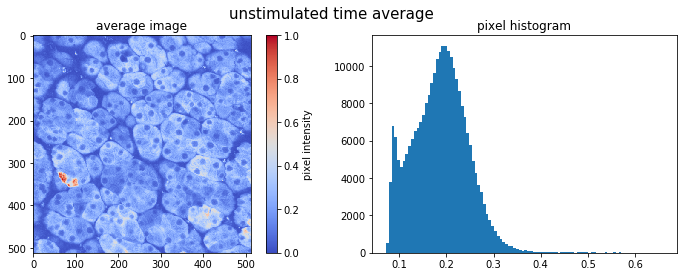

In [4]:
# unstimulated average over time
A = np.concatenate((A0[:stim_start-1,:,:], A0[stim_done:,:,:])) # unstimulated only
M = np.sum(A, axis=0)/A.shape[0]

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle("unstimulated time average", fontsize=15)

ax[0].imshow(M, norm=None, cmap='coolwarm') # image
ax[0].set_title("average image")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=1)
v = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(M.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/unstimulated_time_average.pdf")
plt.show()


#### Stimulated average over time.


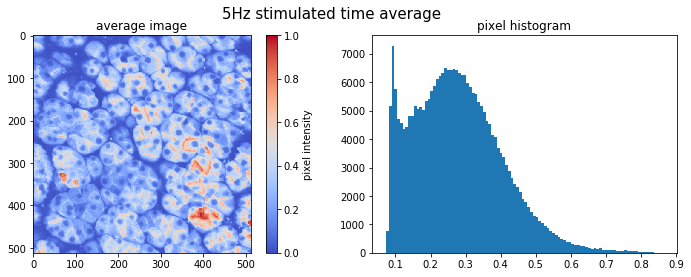

In [5]:
# stimulated average over time
A = A0[stim_start-1:stim_done-1,:,:] # stimulated only
N = np.sum(A, axis=0)/A.shape[0]

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(str(roi_freq) + "Hz stimulated time average", fontsize=15)

ax[0].imshow(N, norm=None, cmap='coolwarm') # image
ax[0].set_title("average image")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=1)
v = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(N.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/stimulated_time_average.pdf")
plt.show()


#### Stimulated minus unstimulated average over time.


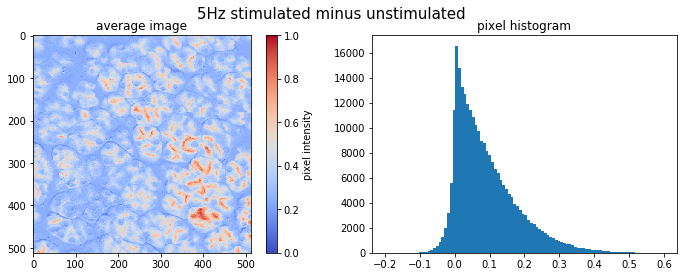

In [6]:
# difference: stimulated - unstimulated
O = N - M

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(str(roi_freq) + "Hz stimulated minus unstimulated", fontsize=15)

ax[0].imshow(O, norm=None, cmap='coolwarm') # image
ax[0].set_title("average image")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=1)
v = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(O.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/stimulated_minus_unstimulated.pdf")
plt.show()


#### Create apical region-of-interest mask.


stimulation frequency: 5Hz
number of apical regions identified:  18
apical ROI values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
apical ROI pixel counts:  [138 130  72 255  94 183  65 302 142 267 215  87  61 105 889 254  87  43]



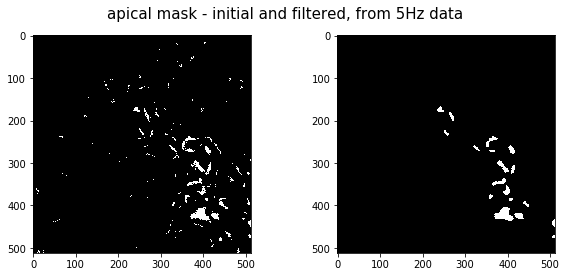

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle("apical mask - initial and filtered, from " + str(roi_freq) + "Hz data", fontsize=15)

# difference threashold filter
P = (O > np.quantile(O,roi_quantile)).astype(float)

# plot image
ax[0].imshow(P, norm=None, cmap='gray');
io.imsave(resultsdir + "/apical_mask_initial.tif", np.int16(P), check_contrast=False)

# filtering: erosion, remove small, then dilation
Q = binary_erosion(P)
Q = remove_small_objects(Q, small_object)
for i in range(dilations):
  Q = binary_dilation(Q)

ax[1].imshow(Q, norm=None, cmap='gray') # plot image
io.imsave(resultsdir + "/apical_mask_filtered.tif", np.int16(Q), check_contrast=False)

# label and get pixel counts
Q, n = label(Q, return_num=True)
io.imsave(resultsdir + "/apical_mask_labelled.tif", np.int16(Q), check_contrast=False)
ROI, COUNT = np.unique(Q, return_counts=True)
print("stimulation frequency: " + str(roi_freq) + "Hz")
print("number of apical regions identified: ", ROI.shape[0]-1)
print("apical ROI values: ", ROI[1:])
print("apical ROI pixel counts: ", COUNT[1:])
print()


#### Plot apical region responses to stimulus.


*********************************************************************
 plots for ../image_stacks/Mistgcamp-3_0002.tif  (5Hz stimulation)
*********************************************************************



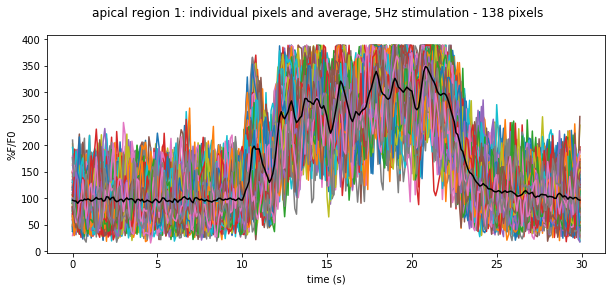

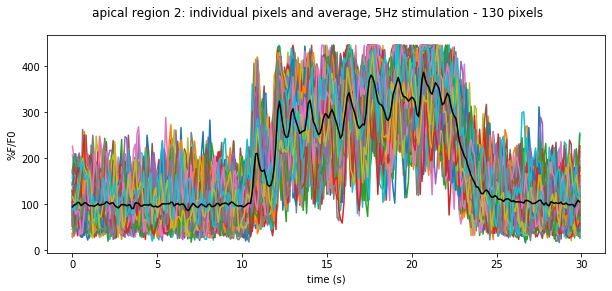

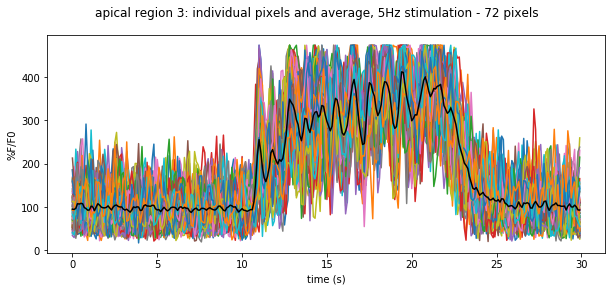

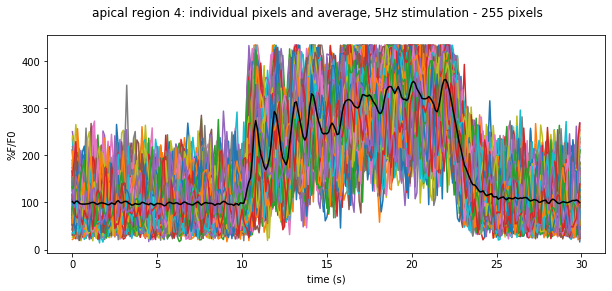

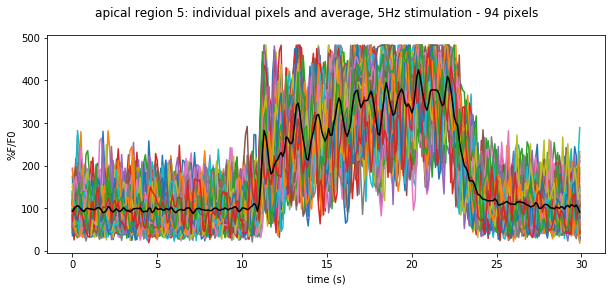

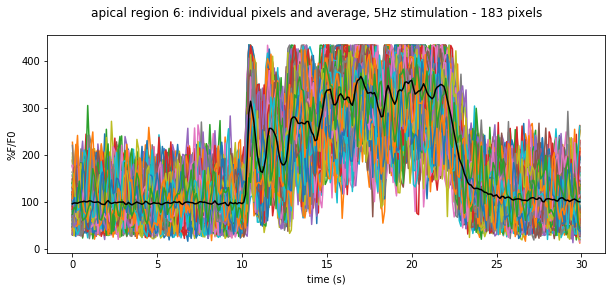

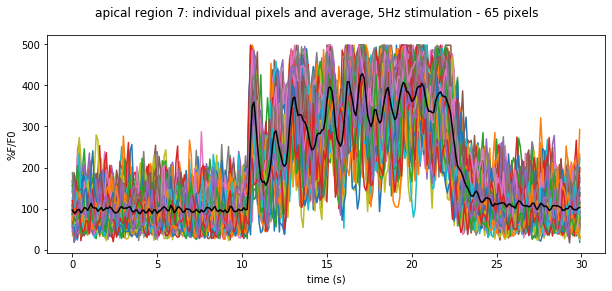

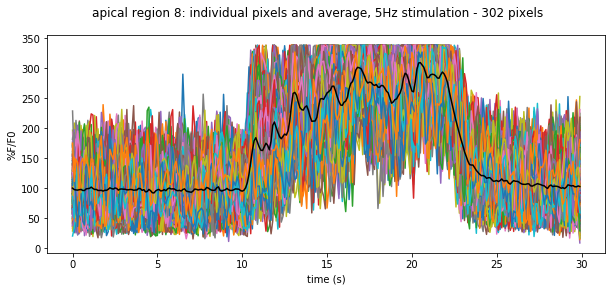

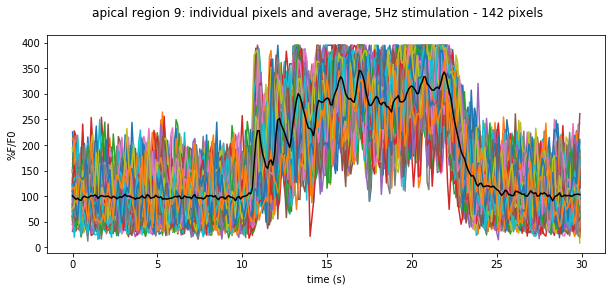

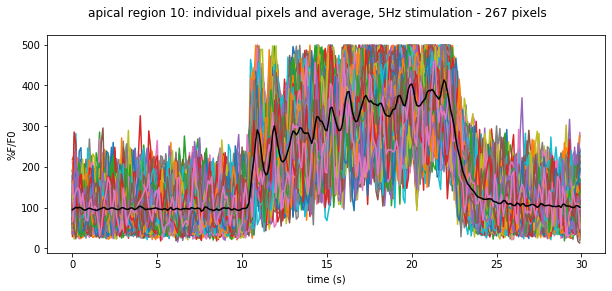

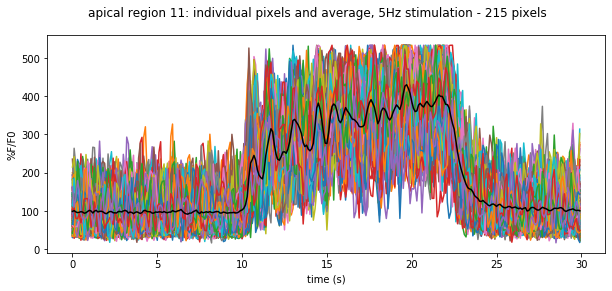

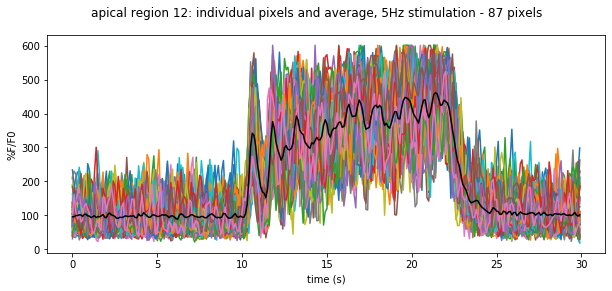

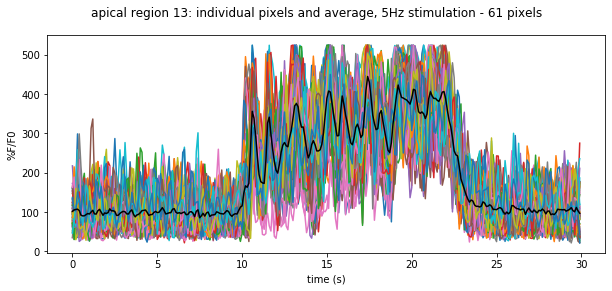

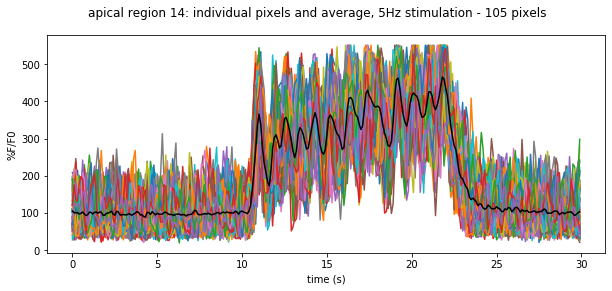

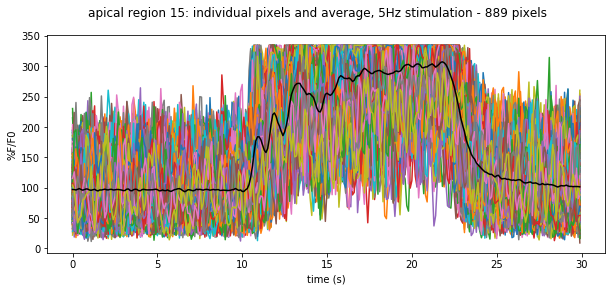

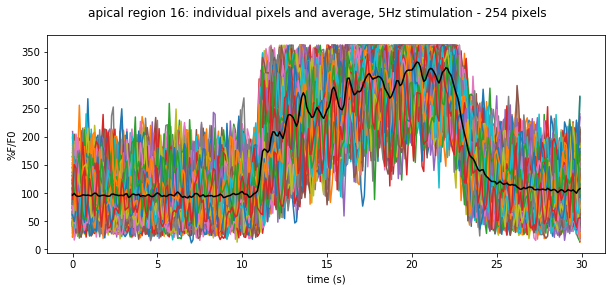

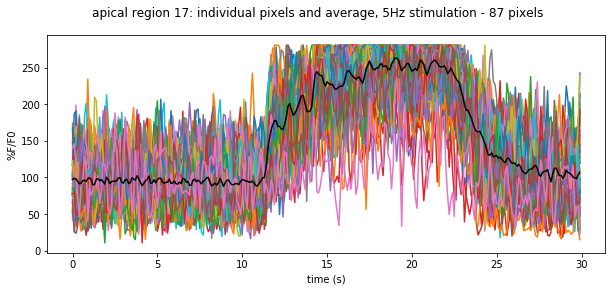

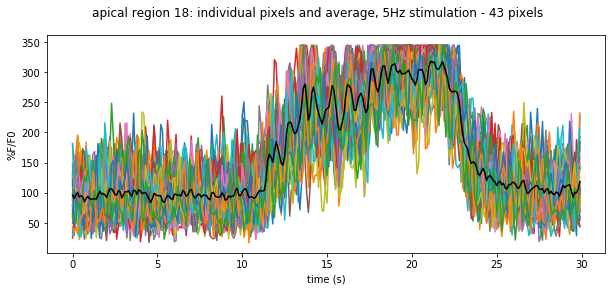

In [26]:
# apical region plots

print("*********************************************************************")
print(" plots for " + image_files[roi_freq] + "  (" + str(roi_freq) + "Hz stimulation)")
print("*********************************************************************")
print()

os.system("rm " + resultsdir + "/apical_region*.pdf") # delete any exiting region pdf's
os.system("rm " + resultsdir + "/apical_data*.csv") # delete any exiting region csv's

RESULTS = np.zeros((len(image_files), ROI.shape[0]-1, A0.shape[0])) # array for all of the apical results
X = np.array(range(A0.shape[0])) * sample_period

with open (resultsdir + "/apical_data_" + '{:02d}'.format(roi_freq) + "Hz.csv", 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["'REGION'", "'DATA'"])

  # create and save plots
  for c in ROI:
    if(c==0):
      continue
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
    fig.suptitle('apical region ' + str(c)+ ": individual pixels and average, " + str(roi_freq) + "Hz stimulation - " +str(COUNT[c]) + " pixels")

    F0 = np.average(M[Q==ROI[c]]) # per region 
    #F0 = M[Q==ROI[c]] # per pixel
    S = 100 * A0[:, Q==ROI[c]] / F0
    T = np.sum(S, axis=1) / S.shape[1]
    RESULTS[list(image_files).index(roi_freq), c-1] = T # save in the results array
    ax.plot(X, S)
    ax.plot(X, T, color='black')
    ax.set(ylabel="%F/F0")
    ax.set(xlabel="time (s)")

    # save figure to pdf
    fig.savefig(resultsdir + "/apical_region_" + str(c) + ".pdf")
    
    # save region number and average plot data to csv
    t = np.concatenate((np.array([float(c)]), T)) # pre-pend the region number
    #t = np.array2string(t, separator=',', formatter={'float_kind':lambda x: '"%.2e"' % x})
    writer.writerow('{:3.3e}'.format(x) for x in t)

    plt.show()
    plt.close() # frees up memory

#### Calculate responses for all other stimulation frequencies using the apical regions from above and plot for all stimulation frequencies by apical region.

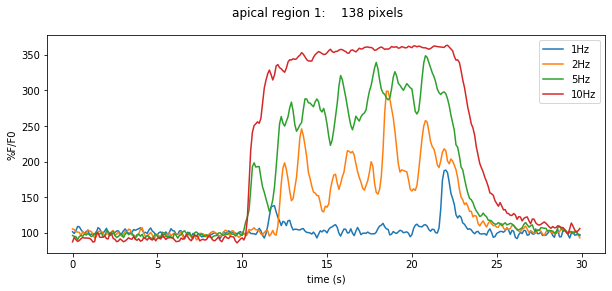

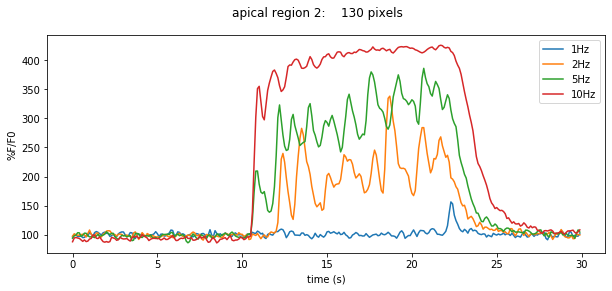

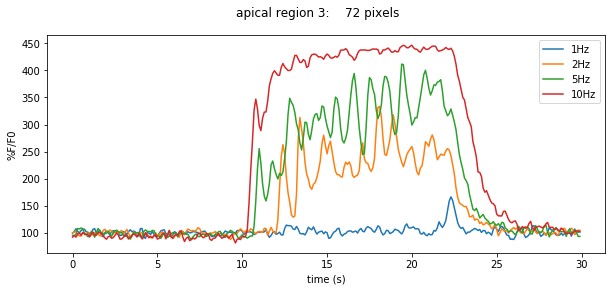

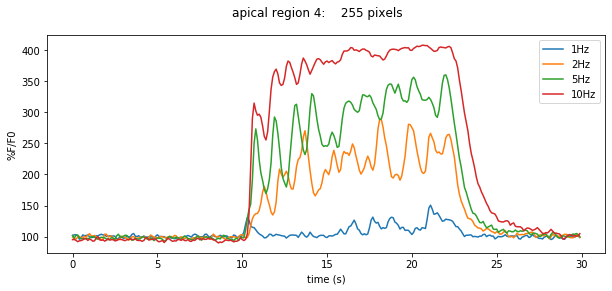

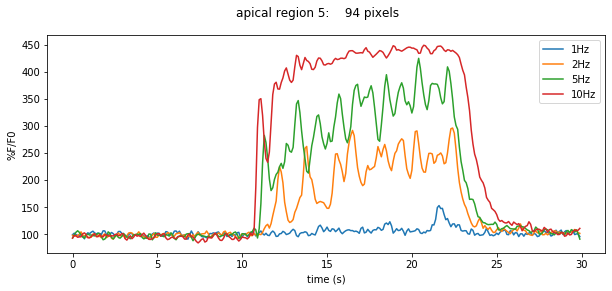

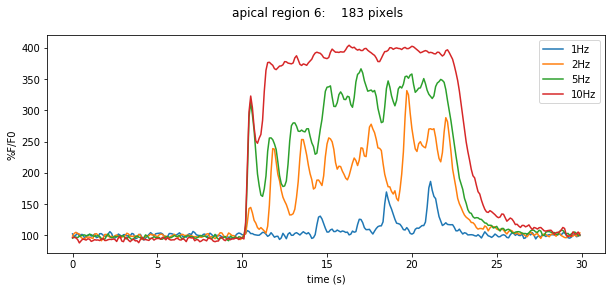

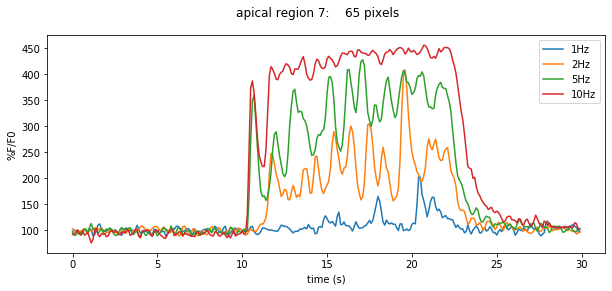

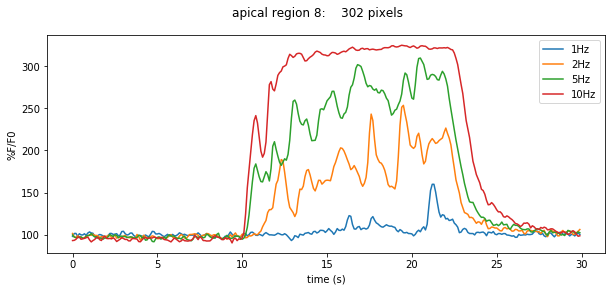

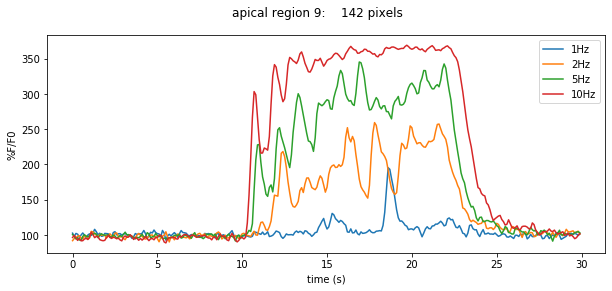

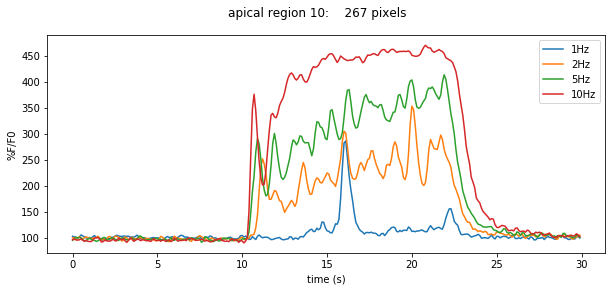

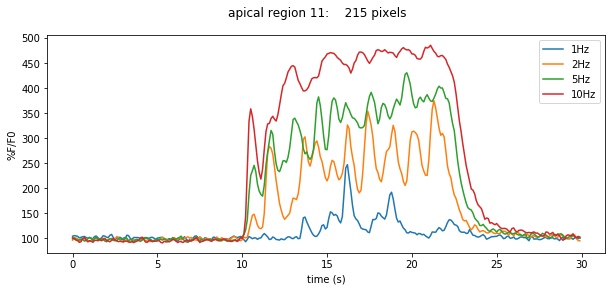

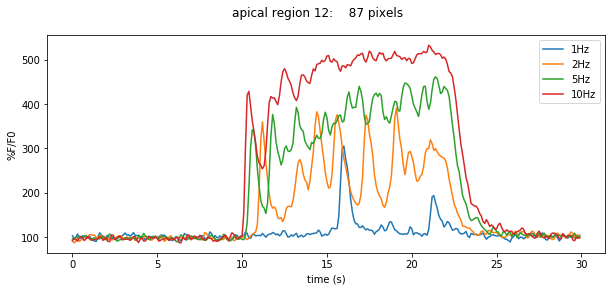

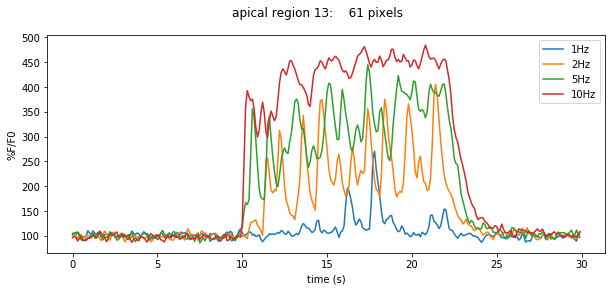

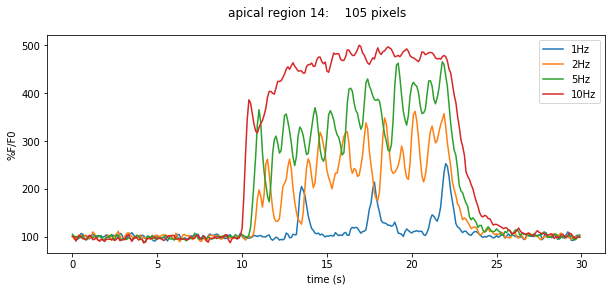

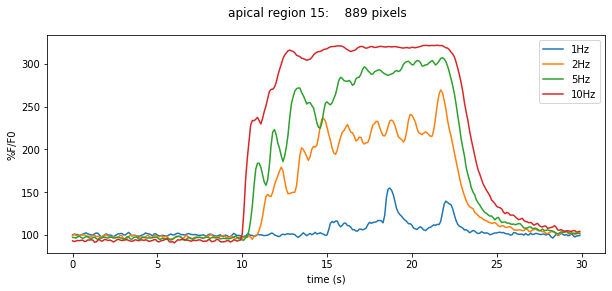

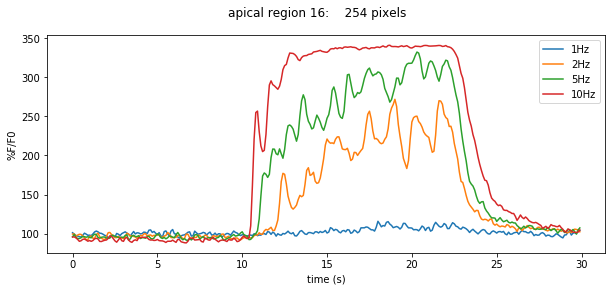

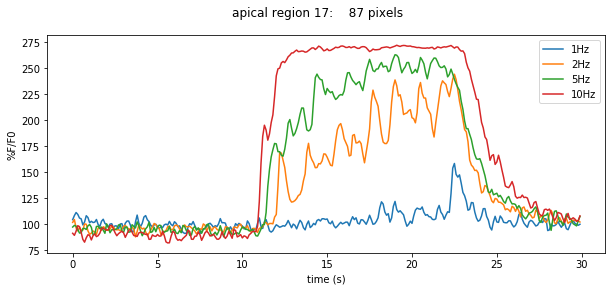

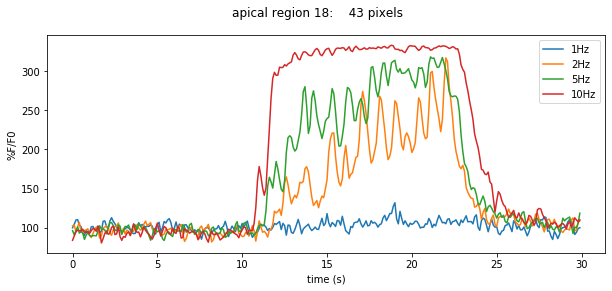

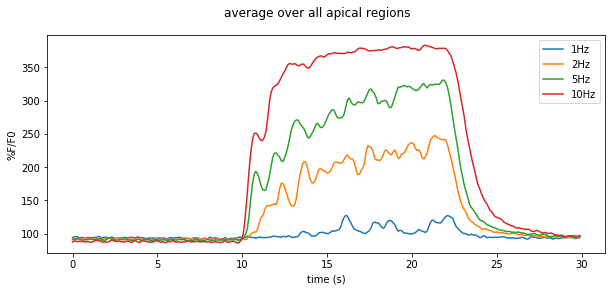

In [27]:
# calculate and save region responses for the other data files
for i in image_files:
  if i==roi_freq:
    continue

  # get other image stack
  A0x = io.imread(image_files[i])
  A0x = np.float32(A0x/(2.0**image_bits))

# average out y-direction aliasing over every other line
  for n in range(A0x.shape[0] - 1): # moving average over every two lines
    A0x[n] = (A0x[n] + A0x[n+1]) / 2.0

  Ax = np.concatenate((A0x[:stim_start-1,:,:], A0x[stim_done:,:,:])) # unstimulated only
  Mx = np.sum(Ax, axis=0)/Ax.shape[0]

  with open (resultsdir + "/apical_data_" + '{:02d}'.format(i) + "Hz.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["'REGION'", "'DATA'"])

    for c in ROI:
      if(c==0):
        continue
      F0 = np.average(Mx[Q==ROI[c]]) # per region 
      S = 100 * A0x[:, Q==ROI[c]] / F0
      T = np.sum(S, axis=1) / S.shape[1]
      RESULTS[list(image_files).index(i), c-1] = T # save in the results array

      # save region number and average plot data to csv
      t = np.concatenate((np.array([float(c)]), T)) # pre-pend the region number
      writer.writerow('{:3.3e}'.format(x) for x in t)

# plot responses for all the stimulation frequencies by region
for n in range(1,len(ROI)):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(ROI[n]) + ":    " + str(COUNT[n]) + " pixels")

  ax.plot(X, np.transpose(RESULTS[:, n-1, :]))
  ax.set(ylabel="%F/F0")
  ax.set(xlabel="time (s)")
  ax.legend(list('{:d}Hz'.format(x) for x in image_files.keys()))

  # save figure to pdf
  fig.savefig(resultsdir + "/apical_region_" + str(n) + "_all.pdf")
    
  plt.show()
  plt.close() # frees up memory

# plot average of region responses for all the stimulation frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
fig.suptitle("average over all apical regions")

ax.plot(X, np.transpose(np.sum(RESULTS, axis=(1)))/len(ROI)-1)
ax.set(ylabel="%F/F0")
ax.set(xlabel="time (s)")
ax.legend(list('{:d}Hz'.format(x) for x in image_files.keys()))

# save figure to pdf
fig.savefig(resultsdir + "/apical_region_all.pdf")
    
plt.show()
plt.close() # frees up memory
